In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# installations for cloud environments
!pip install flwr
!pip install -U flwr["simulation"]
!pip install fast_ml
!pip install imblearn

In [3]:
# for general math functions
import math

# for general data formatting and processing libraries
import numpy as np
import pandas as pd

# parallelize dataset processing
from concurrent.futures import ThreadPoolExecutor

# scaling:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# splitting:
from sklearn.model_selection import train_test_split

# feature selection:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# optimise memory efficiency:
from fast_ml.utilities import reduce_memory_usage

# feature reduction:
from fast_ml.feature_selection import get_constant_features

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# for flower federated learning
from collections import OrderedDict
from typing import List, Tuple, Union, Dict, Optional
import flwr as fl
from flwr.common import Metrics, EvaluateRes, FitRes, Scalar, Parameters
from flwr.server.client_proxy import ClientProxy

# libraries for graphing and logging metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# urls to gather the dataset
mirai = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz'
mirai_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz'

os_scan = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/os_scan/OS%20Scan_dataset.csv.gz'
os_scan_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/os_scan/OS%20Scan_labels.csv.gz'

active_wiretap = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/active_wiretap/Active%20Wiretap_dataset.csv.gz'
active_wiretap_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/active_wiretap/Active%20Wiretap_labels.csv.gz'

ssl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/ssl_renegotiation/SSL%20Renegotiation_dataset.csv.gz'
ssl_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/ssl_renegotiation/SSL%20Renegotiation_labels.csv.gz'

ssdp_flood = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/ssdp_flood/SSDP%20Flood_dataset.csv.gz'
ssdp_flood_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/ssdp_flood/SSDP%20Flood_labels.csv.gz'

syn_dos = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/syn_dos/SYN%20DoS_dataset.csv.gz'
syn_dos_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/syn_dos/SYN%20DoS_labels.csv.gz'

vid_inj = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/video_injection/Video%20Injection_dataset.csv.gz'
vid_inj_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/video_injection/Video%20Injection_labels.csv.gz'

fuzzing = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/fuzzing/Fuzzing_dataset.csv.gz'
fuzzing_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/fuzzing/Fuzzing_labels.csv.gz'

arp_mitm = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/arp_mitm/ARP%20MitM_dataset.csv.gz'
arp_mitm_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00516/arp_mitm/ARP%20MitM_labels.csv.gz'


In [4]:
# dictionary to map to labels
CLASSES = {
    0: "Benign",
    1: "Mirai",
    2: "OS Scan",
    3: "Active Wiretap",
    4: "SSL Renegotiation",
    5: "SSDP Flood",
    6: "SYN DoS",
    7: "Video Injection",
    8: "Fuzzing",
    9: "ARP MitM"
}

In [ ]:
# label, clean, and convert dataset into pandas dataframe (df)
mirai_df = pd.read_csv(mirai, dtype=np.float32, header=None, skiprows=1)
mirai_df = reduce_memory_usage(mirai_df, convert_to_category=False)
mirai_df = mirai_df.drop(columns=[mirai_df.columns[0]]) # drop index column
labels = pd.read_csv(mirai_labels, dtype=int, header=None, skiprows=1)
column_wanted = labels.iloc[:, 0]
mirai_df = pd.concat([mirai_df, column_wanted], axis=1, ignore_index=False)
mirai_df.dropna(inplace=True) # remove any rows with empty values

In [ ]:
# label, clean, and convert dataset into pandas dataframe (df)
def create_dataset(dataset_path, labels_path, target_label:int):
    # read the csv files (always skip header row)
    df = pd.read_csv(dataset_path, dtype=np.float32, header=None, skiprows=1000000)
    df = reduce_memory_usage(df, convert_to_category=False)
    labels = pd.read_csv(labels_path, dtype=int, header=None, skiprows=1000000)
    
    # join label and drop rows with missing values and duplicates
    column_wanted = labels.iloc[:, 1] # labels in the last column
    df_dataset = pd.concat([df, column_wanted], axis=1, ignore_index=False)
    df_dataset.dropna(inplace=True)
    df_dataset.drop_duplicates(inplace=True)
    
    # create new label for different network attacks
    df_dataset.iloc[:, -1] = np.where(df_dataset.iloc[:, -1] == 1, target_label, df_dataset.iloc[:, -1]) 

    return df_dataset

def parallelise_create_dataset(inputs):
    return create_dataset(*inputs)

frames = [
    (os_scan, os_scan_labels, 2),
    (active_wiretap, active_wiretap_labels, 3),
    (ssl, ssl_labels, 4),
    (ssdp_flood, ssdp_flood_labels, 5),
    (syn_dos, syn_dos_labels, 6),
    (vid_inj, vid_inj_labels, 7),
    (fuzzing, fuzzing_labels, 8),
    (arp_mitm, arp_mitm_labels, 9)
]

# parallelise dataset processing:
with ThreadPoolExecutor() as executor:
    outputs = executor.map(parallelise_create_dataset, frames)

os_df, wiretap_df, ssl_df, ssdp_df, syn_df, vid_df, fuzz_df, arp_df = list(outputs)

In [ ]:
# save created datasets
dataset_paths = [
    'mirai_botnet.csv',
    'os_scan.csv',
    'active_wiretap.csv',
    'ssl_renegotiation.csv',
    'ssdp_flood.csv',
    'syn_dos.csv',
    'video_injection.csv',
    'fuzzing.csv',
    'arp_mitm.csv'
]

datasets = [mirai_df, os_df, wiretap_df, ssl_df, ssdp_df, syn_df, vid_df, fuzz_df, arp_df]

def save_dataset(data):
    dataset, path = data
    dataset = reduce_memory_usage(dataset, convert_to_category=False)
    dataset.to_csv(path, index=False, header=False)

# parallelise the saving
with ThreadPoolExecutor() as executor:
    executor.map(save_dataset, zip(datasets, dataset_paths))

In [ ]:
# read saved dataset
def read_dataset(path):
    df = pd.read_csv(path, header=None)
    df = reduce_memory_usage(df, convert_to_category=False)
    return df

with ThreadPoolExecutor() as executor:
    out = executor.map(read_dataset, dataset_paths)
    dfs = list(out)

In [ ]:
# drop samples of benign network traffic to balance the distribution of labels
# since instances of the class is significantly too much compared to the others
dfs[1] = dfs[1].iloc[300000:-200000]
dfs[3] = dfs[3].drop(range(310000))
dfs[4] = dfs[4].drop(range(1600000))
dfs[5] = dfs[5].drop(range(1680000))
dfs[6] = dfs[6].drop(range(1130000))
dfs[7] = dfs[7].drop(range(200000))
dfs[8] = dfs[8].drop(range(200000))

index: Int64Index([1, 0], dtype='int64'), counts: [642516 121620]


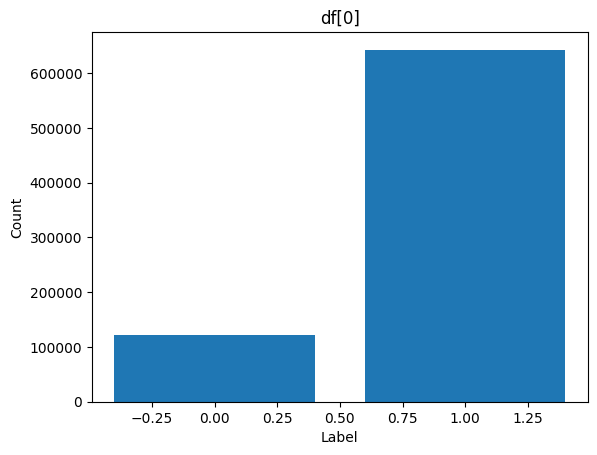

index: Int64Index([0, 2], dtype='int64'), counts: [132193  65659]


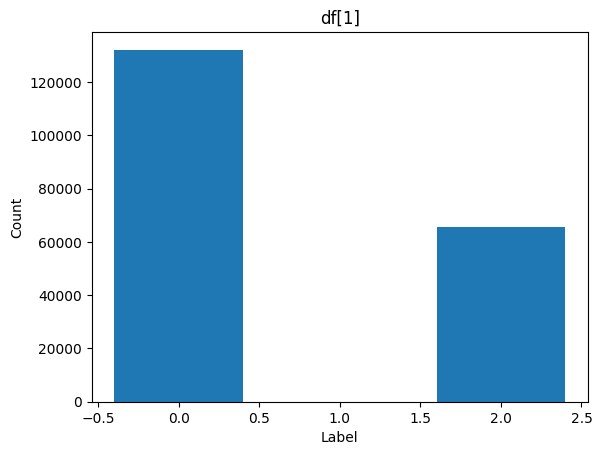

index: Int64Index([3, 0], dtype='int64'), counts: [923215 355474]


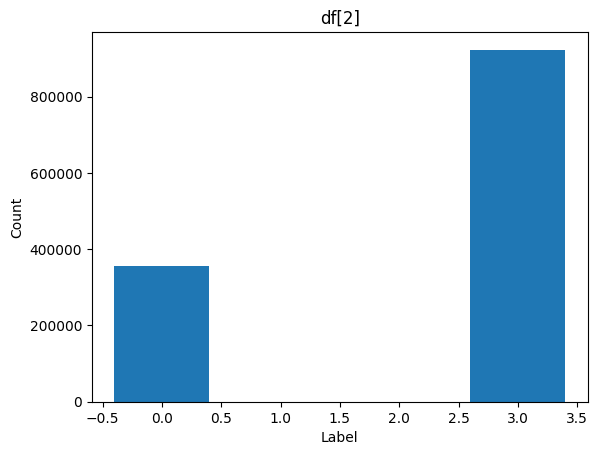

index: Int64Index([0, 4], dtype='int64'), counts: [804921  92651]


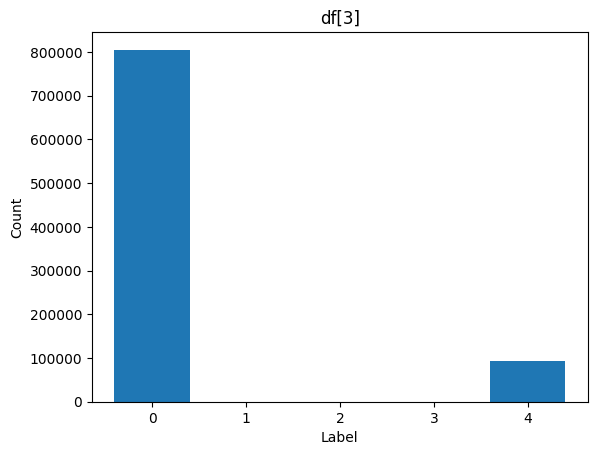

index: Int64Index([5, 0], dtype='int64'), counts: [1439603   37663]


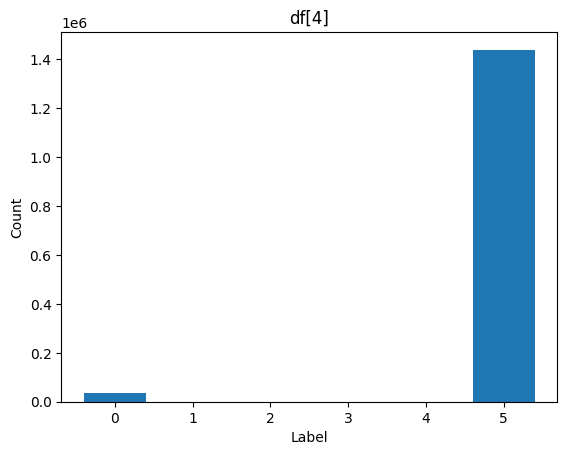

index: Int64Index([0, 6], dtype='int64'), counts: [84240  7037]


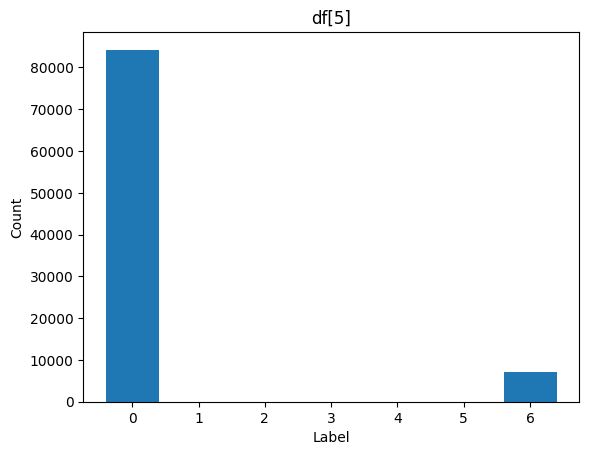

index: Int64Index([0, 7], dtype='int64'), counts: [239904 102498]


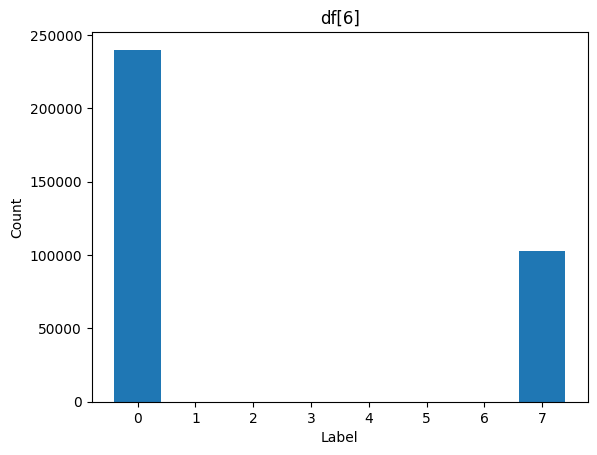

index: Int64Index([0, 8], dtype='int64'), counts: [611357 432783]


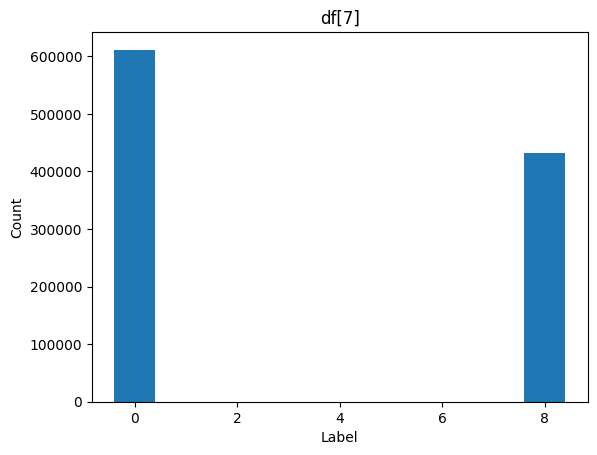

index: Int64Index([9, 0], dtype='int64'), counts: [1145271  158997]


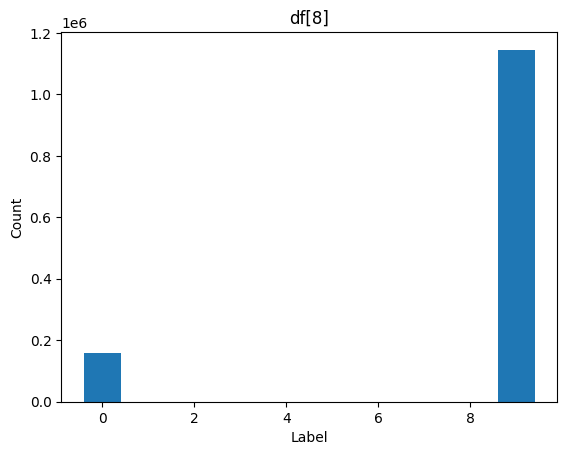

In [ ]:
# review the distribution of labels
for i, df in enumerate(dfs):
    label_counts = df.iloc[:, -1].value_counts()
    print(f"index: {label_counts.index}, counts: {label_counts.values}")
    plt.bar(label_counts.index, label_counts.values)
    plt.title(f'df[{i}]')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

In [ ]:
# save the distribution changes
def save_dataset(data):
    dataset, path = data
    dataset = reduce_memory_usage(dataset, convert_to_category=False)
    dataset.to_csv(path, index=False, header=False)

# parallelise the saving
with ThreadPoolExecutor() as executor:
    executor.map(save_dataset, zip(dfs, dataset_paths))

In [ ]:
# concatenate the dataframes
frame = pd.concat(dfs)

# visualise the class distribution for the overall dataset
# using a bar graph
label_counts = frame.iloc[:, -1].value_counts()
classes = [CLASSES[i] for i in label_counts.index] # map indices to previously defined classes
plt.barh(classes, label_counts.values)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

# print the value of each class
for i, count in enumerate(label_counts.values):
    class_name = CLASSES[label_counts.index[i]]
    print(f'{class_name}: {count}')

In [ ]:
# search and remove constant/quasi-constant features
constant_features = get_constant_features(frame)
print(constant_features)
columns_to_drop = constant_features['Var'].tolist()
frame = frame.drop(columns_to_drop, axis=1)

             Desc  Var  Value       Perc
0  Quasi Constant   85    0.0  99.746850
1  Quasi Constant   86    0.0  99.666243
2  Quasi Constant   92    0.0  99.585933
3  Quasi Constant   93    0.0  99.449132


In [ ]:
# save reduced features
frame = reduce_memory_usage(frame, convert_to_category=False)
frame.to_csv('truncated_data.csv', index=False, header=False)

In [ ]:
# read csv data and transform into np arrays
frame = pd.read_csv('../Thesis/frames/truncated_data.csv', header=None)
frame = reduce_memory_usage(frame, convert_to_category=False)

In [ ]:
# split dataset into training, test, and validation sets
# distribute classes evenly to both sets with stratified sampling

X = frame.iloc[:, :-1] # features
y = frame.iloc[:, -1] # target label

# create subset of the dataset as its too large for efficient computation
X_subset, _, y_subset, _ = train_test_split(X, y, test_size=0.9, random_state=23, stratify=y)

# test set is 20% of the full dataset
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=23, stratify=y_subset)

# validation set is 20% of the training set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=23, stratify=y_train)


In [ ]:
# save the splits
np.save('../Thesis/numpys/X_train.npy', X_train)
np.save('../Thesis/numpys/y_train.npy', y_train)

np.save('../Thesis/numpys/X_validation.npy', X_validation)
np.save('../Thesis/numpys/y_validation.npy', y_validation)

np.save('../Thesis/numpys/X_test.npy', X_test)
np.save('../Thesis/numpys/y_test.npy', y_test)

In [ ]:
# scale the datasets
normaliser = MinMaxScaler()
standardiser = StandardScaler()

# normalise datasets for feature selection
X_train_stand = standardiser.fit_transform(X_train)
X_test_stand = standardiser.transform(X_test)
X_validation_stand = standardiser.transform(X_validation)

X_train_norm = normaliser.fit_transform(X_train)
X_test_norm = normaliser.transform(X_test)
X_validation_norm = normaliser.transform(X_validation)

In [ ]:
# save the scaled datasets
np.save('../Thesis/numpys/X_train_scaled.npy', X_train_norm)
np.save('../Thesis/numpys/X_validation_scaled.npy', X_validation_norm)
np.save('../Thesis/numpys/X_test_scaled.npy', X_test_norm)

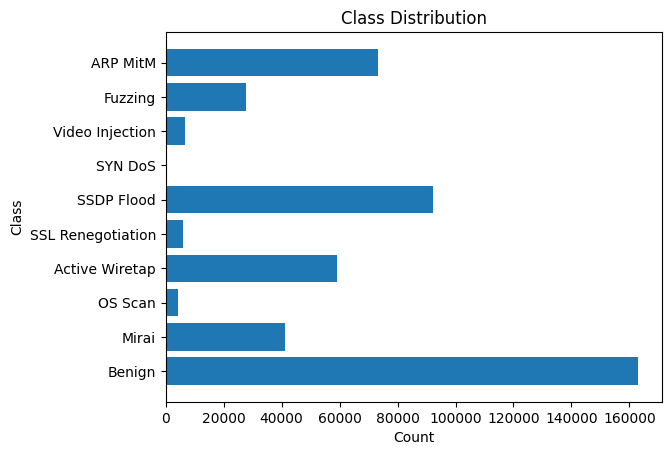

Benign, 0: 162967
Mirai, 1: 41122
OS Scan, 2: 4202
Active Wiretap, 3: 59086
SSL Renegotiation, 4: 5930
SSDP Flood, 5: 92134
SYN DoS, 6: 450
Video Injection, 7: 6560
Fuzzing, 8: 27698
ARP MitM, 9: 73297


In [ ]:
# view the class distribution for the training set to check for imbalancing
label_counts = np.bincount(y_train)
classes = [CLASSES[i] for i in range(len(label_counts))] # map indices to previously defined classes
plt.barh(classes, label_counts)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.savefig('../Thesis/images/original_class_distribution')
plt.show()

# print the count of each class
for i, count in enumerate(label_counts):
    class_name = CLASSES[i]
    print(f'{class_name}, {i}: {count}')

In [ ]:
# random undersampling to balance class distribution
sampling_strategy = {
    0: 250000
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=23, replacement=False)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_scaled, y_train)

In [ ]:
# oversampling with SMOTE for under-represented classes
sampling_strategy = {
    4: 59300, # x4 the original samples
    2: 42024, # x4 the original samples
    6: 4504 # x4 the original samples
}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=23)
X_train_smote, y_train_smote = smote.fit_resample(X_train_undersampled, y_train_undersampled)

In [ ]:
# save resampled trainset
np.save('../Thesis/numpys/X_train_resampled.npy', X_train_smote)
np.save('../Thesis/numpys/y_train_resampled.npy', y_train_smote)

In [ ]:
# load the saved datasets
X_train_scaled = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/X_train_scaled.npy')
y_train = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/y_train.npy')

X_validation_scaled = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/X_validation_scaled.npy')
y_validation = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/y_validation.npy')

X_test_scaled = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/X_test_scaled.npy')
y_test = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/y_test.npy')

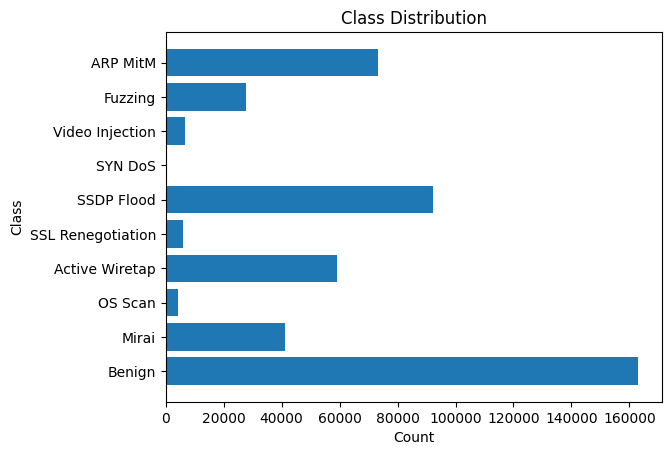

Benign: 162967
Mirai: 41122
OS Scan: 4202
Active Wiretap: 59086
SSL Renegotiation: 5930
SSDP Flood: 92134
SYN DoS: 450
Video Injection: 6560
Fuzzing: 27698
ARP MitM: 73297


In [ ]:
# view the class distribution for the training set
label_counts = np.bincount(y_train)
classes = [CLASSES[i] for i in range(len(label_counts))] # map indices to previously defined classes
plt.barh(classes, label_counts)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.savefig('resampled_class_distribution')
plt.show()

# print the count of each class
for i, count in enumerate(label_counts):
    class_name = CLASSES[i]
    print(f'{class_name}: {count}')

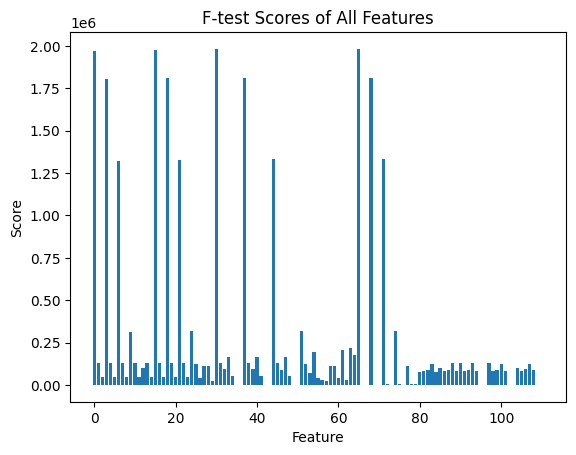

In [ ]:
# calculate the ANOVA F-test score of all features using SelectKBest
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_scaled, y_train)
scores = selector.scores_

# plot on a bar graph to view F-test scores of all features
plt.bar(range(len(scores)), scores)
plt.title('F-test Scores of All Features')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.savefig('all_ftest')
plt.show()

Accuracy for k=10: 75.96653
Accuracy for k=20: 90.71050
Accuracy for k=30: 91.38910
Accuracy for k=40: 91.38504
Accuracy for k=50: 91.86696
Accuracy for k=60: 91.83857
Accuracy for k=70: 91.91765
Accuracy for k=80: 91.85614
Accuracy for k=90: 91.97375
Accuracy for k=100: 91.97307
Accuracy for k=110: 92.00957


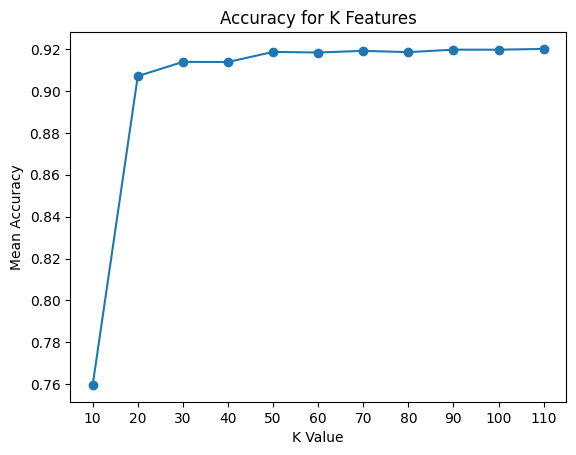

In [ ]:
# train decision tree classifier and evaluate accuracy on test set
# to decide the best k features to use
selector = SelectKBest(score_func=f_classif)
k_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
acc = []

for k in k_values:
    selector.set_params(k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_selected, y_train)

    pred_y_test = dtc.predict(X_test_selected)
    accuracy = accuracy_score(y_test, pred_y_test)
    acc.append(accuracy)
    print(f'Accuracy for k={k}: {accuracy*100:.5f}')


# plot the results
plt.plot(k_values, acc, marker='o')
plt.title('Accuracy for K Features')
plt.xlabel('K Value')
plt.ylabel('Mean Accuracy')
plt.xticks(k_values)
plt.savefig('dtc_kaccuracy')
plt.show()

In [ ]:
# feature select for the datasets
selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_validation_selected = selector.transform(X_validation_scaled)
X_test_selected = selector.transform(X_test_scaled)

In [ ]:
# append labels and reformat the datasets
train_set = np.c_[X_train_selected, y_train]
val_set = np.c_[X_validation_selected, y_validation]
test_set = np.c_[X_test_selected, y_test]

print(len(train_set))
print(len(val_set))
print(len(test_set))

473446
118362
147952


In [ ]:
np.save('../Thesis/numpys/trainset10.npy', train_set)
np.save('../Thesis/numpys/valsetk50.npy', val_set)
np.save('../Thesis/numpys/testsetk50.npy', test_set)

In [66]:
train_set = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/trainset10.npy')
val_set = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/valset10.npy')
test_set = np.load('/content/gdrive/My Drive/Thesis Data/full_features_data/testset10.npy')

In [5]:
train_set = np.load('/content/gdrive/My Drive/Thesis Data/feature_reduced_data/trainsetk50.npy')
val_set = np.load('/content/gdrive/My Drive/Thesis Data/feature_reduced_data/valsetk50.npy')
test_set = np.load('/content/gdrive/My Drive/Thesis Data/feature_reduced_data/testsetk50.npy')

In [6]:
# set parameters for data partitioning and loading:
BATCH_SIZE = 16
NUM_CLIENTS = 4

In [7]:
# create custom pytorch dataset for tensorisation
class PyTorchDataset(Dataset):
    def __init__(self, numpy_array):
        self.features = torch.from_numpy(numpy_array[:, :-1]).to(torch.float32)
        self.labels = torch.from_numpy(numpy_array[:, -1]).to(torch.long) # for CrossEntropyLoss calculation

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [8]:
### Data partitioning ###
# Cross-device federated learning is assumed
# therefore dataset is split into clients to simulate this:

# Partition the datasets for federated learning
def partition(trainset, valset, num_clients:int):
    partitioned_train = np.array_split(trainset, num_clients)
    partitioned_val = np.array_split(valset, num_clients)
    return partitioned_train, partitioned_val


def partition_noniid(dataset, num_clients:int):
    # gather labels
    labels = np.unique(dataset[:, -1])
    partitioned_dataset = []

    for i in range(num_clients):
        # Get all the data points in the dataset corresponding to a particular label
        client_data = dataset[dataset[:,-1] == labels[i]]

        # assign these data points to a client
        partitioned_dataset.append(client_data)

    return partitioned_dataset

partitioned_trainset, partitioned_valset = partition(train_set, val_set, NUM_CLIENTS)
# partitioned_trainset = partition_noniid(train_set, NUM_CLIENTS)
# partitioned_valset = partition_noniid(val_set, NUM_CLIENTS)

In [9]:
### Data loading ###
# create pytorch dataloaders without partitioning for centralised learning baseline
def load_dataset(dataset):
    transformed_set = PyTorchDataset(dataset)
    dataloader = DataLoader(transformed_set, batch_size=BATCH_SIZE, shuffle=False)
    return dataloader
  
trainloader = load_dataset(train_set)
valloader = load_dataset(val_set)

# create pytorch dataloaders of the partitioned training and validation sets
# and the test set
def load_datasets(trainset, valset, testset):
    # Each partition is transformed and loaded
    trainloaders = []
    valloaders = []
  
    for partition in trainset:
        # Transform subsets
        train_subset = PyTorchDataset(partition)

        # create the dataloaders for pytorch
        trainloaders.append(DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False))
        
    
    for partition in valset:
        # Transform subsets
        val_subset = PyTorchDataset(partition)

        # create the dataloaders for pytorch
        valloaders.append(DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False))

    test_set = PyTorchDataset(testset)
    testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    return trainloaders, valloaders, testloader

# load datasets
trainloaders, valloaders, testloader = load_datasets(partitioned_trainset, partitioned_valset, test_set)

In [10]:
# Check if data is partitioned and loaded correctly
print("Training set length per partition: ", len(trainloaders[0].dataset))
print("Training loaders partitions length: ", len(trainloaders))
print("Validation set length per partition: ", len(valloaders[0].dataset))
print("Training set length (Non-partitioned): ", len(trainloader.dataset))
print("Validation set length (Non-partitioned): ", len(valloader.dataset))
print("Test set length: ", len(testloader.dataset))

Training set length per partition:  118362
Training loaders partitions length:  4
Validation set length per partition:  29591
Training set length (Non-partitioned):  473446
Validation set length (Non-partitioned):  118362
Test set length:  147952


In [96]:
# defining the LTSM model
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size # hidden state
        self.dropout_prob = dropout_prob # dropout probability

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected layer 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_prob)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0)) # lstm with input, hidden, and internal state
        out = self.relu(hn[-1]) # using hidden state of last layer
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.dropout(out) # dropout layer
        out = self.fc(out) # final output layer
        
        return out

In [11]:
# defining the DNN model
class DNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.dropout_prob = dropout_prob

        self.fc_input = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers-1)]
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten input to connect to fully connected layers

        # Propagate input through the input layer
        x = self.fc_input(x)
        x = self.relu(x)

        # propagate through the hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
            #x = self.dropout(x)

        # propagate through the fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)

        return x

In [12]:
def train(model, trainloader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train() # switch to train mode
    correct, total, loss = 0, 0, 0.0
    loss_count = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad() # zero parameter gradients

        # forward pass
        output = model(inputs)
        loss = criterion(output, labels)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        loss_count += loss.item() # update loss

        # compute accuracy
        total += labels.size(0)
        correct += (torch.max(output.data, 1)[1] == labels).sum().item()
    
    # log results of training
    loss = loss_count / len(trainloader.dataset)
    acc = correct / total

    return loss, acc


def test(model, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval() # switch to evaluation mode
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # forward pass + loss update
            output = model(inputs)
            loss += criterion(output, labels).item()

            # compute accuracy
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()
            
    # log results of testing
    loss = loss / len(testloader.dataset)
    acc = correct / total

    return loss, acc

In [13]:
# train on GPU, if available:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check pytorch and flower version
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [14]:
# get the updated model parameters from a local model
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# update the clients local model with parameters received from the server 
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = model.state_dict()
    for k, v in params_dict:
        state_dict[k] = torch.Tensor(v)
    model.load_state_dict(state_dict, strict=True)

In [15]:
# set model parameters from aggregated parameters to save
def set_model_params(model, params):
    """Set model parameters from a list of ndarrays."""
    for param, state_dict in zip(params, model.state_dict().values()):
        state_dict.copy_(torch.from_numpy(param))

In [16]:
# define client-side federated training and evaluation
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid # to log additional details
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        # empty config log means no calls to the get_parameters method above 
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


# define a single Flower client
def client_fn(cid: str) -> FlowerClient:
    # Load model
    model = DNN(num_classes=10, input_size=50, hidden_size=32, num_layers=1).to(DEVICE)

    # load data for each client to train and evaluate
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    
    return FlowerClient(cid, model, trainloader, valloader)

In [17]:
# define a weighted averaging function to aggregate evaluation metrics
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # multiply accuracy of each client by number of examples used for weighting
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # aggregate to get weighted average
    return {"accuracy": sum(accuracies) / sum(examples)}

In [19]:
# extend class to save trained model for evaluation later:
class SaveModelStrategy(fl.server.strategy.FedProx):
    def __init__(self, *args, model_fn, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_fn = model_fn

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:

        # call aggregate_fit from the strategy class to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            # convert parameters to a list of n dimensional arrays
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # create pytorch model instance and set their parameters
            model = self.model_fn()
            set_parameters(model, aggregated_ndarrays)

            # save model
            torch.save(model.state_dict(), f"model_round_{server_round}.pt")

        return aggregated_parameters, aggregated_metrics

In [20]:
# create model instance for each client in federated learning strategy
def create_model():
    return DNN(num_classes=10, input_size=50, hidden_size=32, num_layers=1)

# get initial parameters for server-side parameter initialisation from a model instance
init_params = get_parameters(DNN(num_classes=10, input_size=50, hidden_size=32, num_layers=1))

# specify client resources if gpu is available
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

In [ ]:
# create federated learning strategy
strategy = SaveModelStrategy(
    model_fn=create_model,
    fraction_fit=0.2,  # % of available clients for training
    fraction_evaluate=0.2,  # % of available clients for evaluation
    min_fit_clients=4, 
    min_evaluate_clients=4, 
    min_available_clients=NUM_CLIENTS,  # wait until all specified clients are available
    initial_parameters=fl.common.ndarrays_to_parameters(init_params), # server-side parameter initialisation
    evaluate_metrics_aggregation_fn=weighted_average,  # metric aggregation function
    proximal_mu = 0.1 # proximal term for FedProx
)

# start simulation
result = fl.simulation.start_simulation(
    client_fn=client_fn, # create the client instances
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

In [22]:
# modified test function to track metrics for test set evaluation
def log_test(model, testloader):
    true_class = []
    pred_class = []
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # forward pass + loss update
            output = model(inputs)
            loss += criterion(output, labels).item()

            # compute accuracy
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

            # track results for the graph
            for label in labels.cpu().data.numpy():
                true_class.append(label)
            for prediction in model(inputs).cpu().data.numpy().argmax(1):
                pred_class.append(prediction)
            
    # log results of testing
    loss = loss / len(testloader.dataset)
    acc = correct / total

    return loss, acc, true_class, pred_class

Test Set: Loss 0.019677623072177828, Accuracy 0.8739861576727588


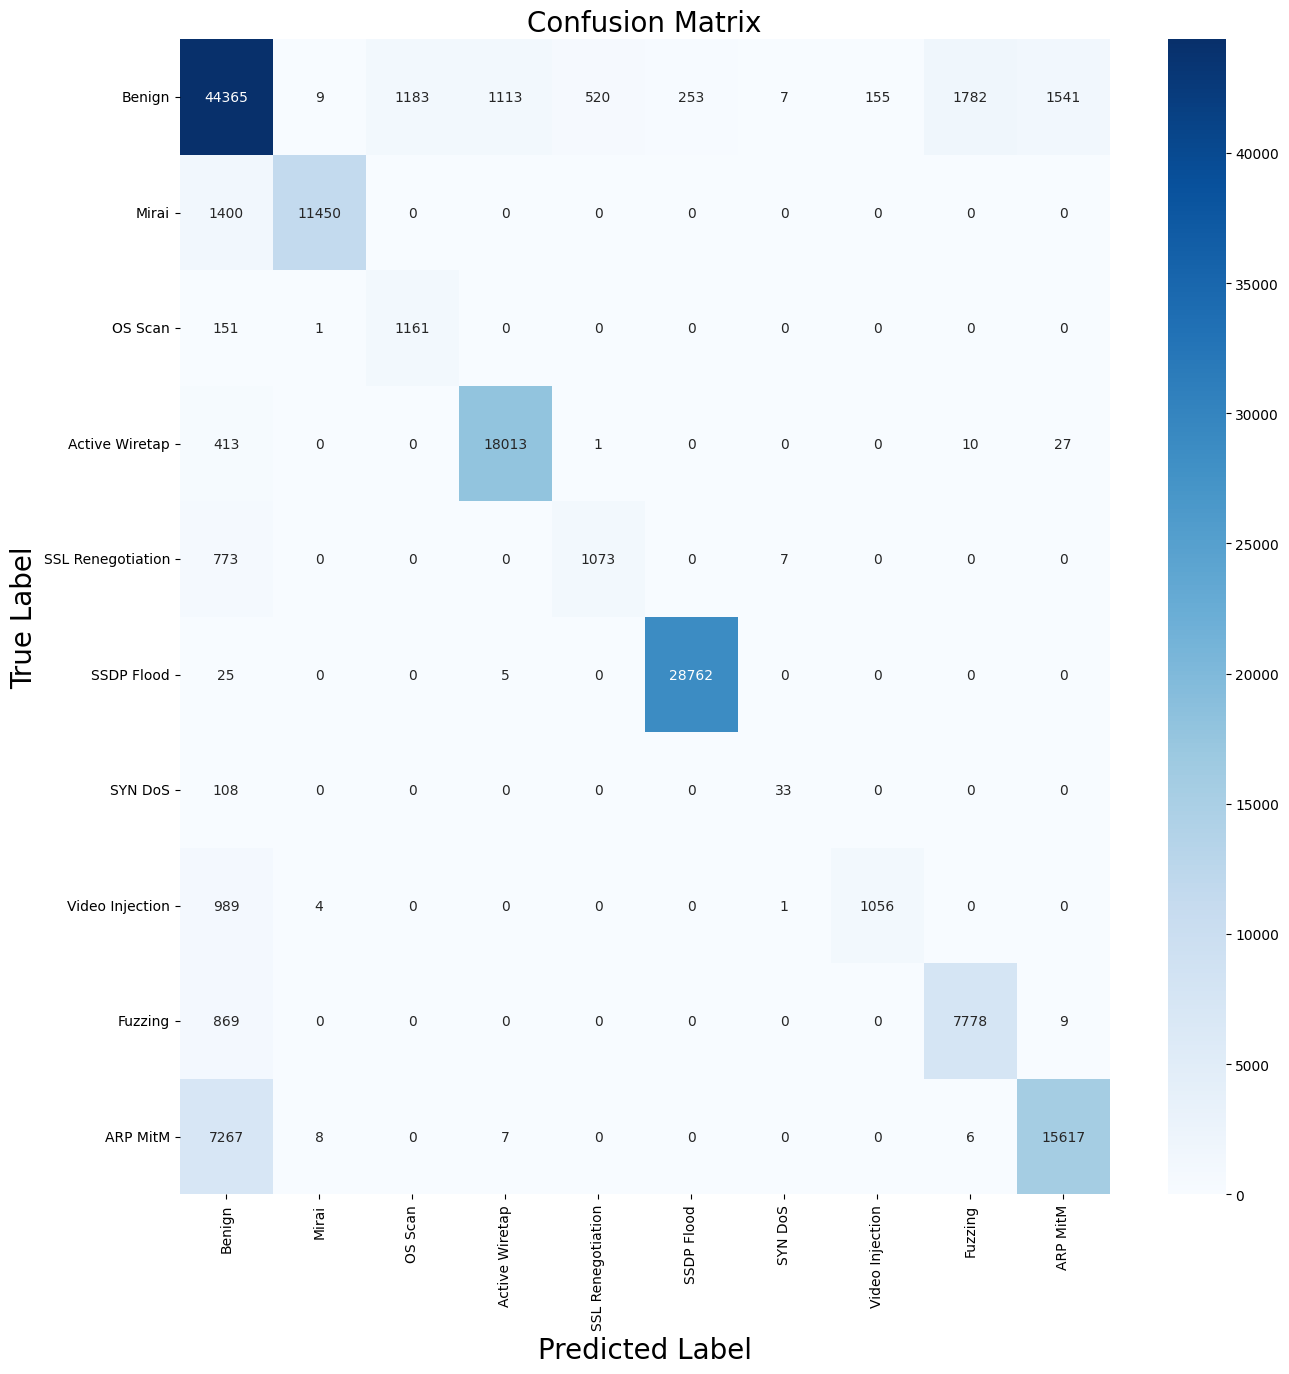

                   precision    recall  f1-score   support

           Benign       0.79      0.87      0.83     50928
            Mirai       1.00      0.89      0.94     12850
          OS Scan       0.50      0.88      0.63      1313
   Active Wiretap       0.94      0.98      0.96     18464
SSL Renegotiation       0.67      0.58      0.62      1853
       SSDP Flood       0.99      1.00      1.00     28792
          SYN DoS       0.69      0.23      0.35       141
  Video Injection       0.87      0.52      0.65      2050
          Fuzzing       0.81      0.90      0.85      8656
         ARP MitM       0.91      0.68      0.78     22905

         accuracy                           0.87    147952
        macro avg       0.82      0.75      0.76    147952
     weighted avg       0.88      0.87      0.87    147952



In [23]:
# evaluate federated learning:
# load saved model
MODEL_PATH = '/content/gdrive/My Drive/Thesis Data/models/fedprox_k50.pt'
pre_federated_model = DNN(num_classes=10, input_size=50, hidden_size=32, num_layers=1).to(DEVICE)
pre_federated_model.load_state_dict(torch.load(MODEL_PATH))

# evaluate federated learned model on test set:
test_loss, test_acc, true_class, pred_class = log_test(pre_federated_model, testloader)
print(f"Test Set: Loss {test_loss}, Accuracy {test_acc}")

# view a confusion matrix of the test set results
cm = confusion_matrix(true_class, pred_class)
class_labels = list(CLASSES.values())
tick_marks = np.arange(len(class_labels))
df_cm = pd.DataFrame(cm, index = class_labels, columns = class_labels)
plt.figure(figsize = (15,15))
hm = sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted Label", fontsize=20)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
plt.ylabel("True Label", fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.savefig('/content/gdrive/My Drive/Thesis Data/eval/cm/fedprox_k50')
plt.show()

# print precision and recall
federated_results = classification_report(true_class, pred_class, target_names=class_labels)
print(federated_results)


In [24]:
# save results
with open('/content/gdrive/My Drive/Thesis Data/eval/reports/fedprox_results_k50.txt', 'w') as f:
    f.write(federated_results)

In [46]:
# count the number of trainable parameters the model is using for experimentation
def count_trainable_parameters(model):
    parameters = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            parameters += parameter.numel()
            
    return parameters

In [47]:
# for training the centralised learning baseline:
# arrays to track and plot metrics for centralised training
track_epoch = []
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# reset the trackers for each training session
track_epoch.clear()
training_loss.clear()
validation_loss.clear()
training_accuracy.clear()
validation_accuracy.clear()

# train model using centralised learning as baseline
model = DNN(num_classes=10, input_size=50, hidden_size=32, num_layers=1).to(DEVICE)

# Count the number of trainable parameters in the model
num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params}")

for epoch in range(10):
    train_loss, train_acc = train(model, trainloader)
    val_loss, val_acc = test(model, valloader)
    
    print(f"Training: Epoch {epoch+1}: Loss {train_loss}, Accuracy {train_acc}")
    print(f"Validation: Epoch {epoch+1}: Loss {val_loss}, Accuracy {val_acc}")

    track_epoch.append(epoch)
    training_loss.append(float(train_loss))
    validation_loss.append(float(val_loss))
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)

# save model
torch.save(model.state_dict(), 'centralised_round10.pt')

Number of trainable parameters: 4394
Training: Epoch 1: Loss 0.02911445041516375, Accuracy 0.8197851497319653
Validation: Epoch 1: Loss 0.023069625019588293, Accuracy 0.8599043611970058
Training: Epoch 2: Loss 0.02280308294358246, Accuracy 0.8567059390088838
Validation: Epoch 2: Loss 0.021223333153561903, Accuracy 0.8627093154897687
Training: Epoch 3: Loss 0.02159003521922935, Accuracy 0.8620349522437617
Validation: Epoch 3: Loss 0.02023610786619872, Accuracy 0.8635203866105676
Training: Epoch 4: Loss 0.02092112361559741, Accuracy 0.8651166130878706
Validation: Epoch 4: Loss 0.019996529537553355, Accuracy 0.8644328416214664
Training: Epoch 5: Loss 0.020467597709523513, Accuracy 0.8668633804066356
Validation: Epoch 5: Loss 0.022194722996708754, Accuracy 0.8536270086683226
Training: Epoch 6: Loss 0.020167967171030112, Accuracy 0.8684179399551374
Validation: Epoch 6: Loss 0.019497910051322655, Accuracy 0.8699160203443673
Training: Epoch 7: Loss 0.01996023968111882, Accuracy 0.869171985823

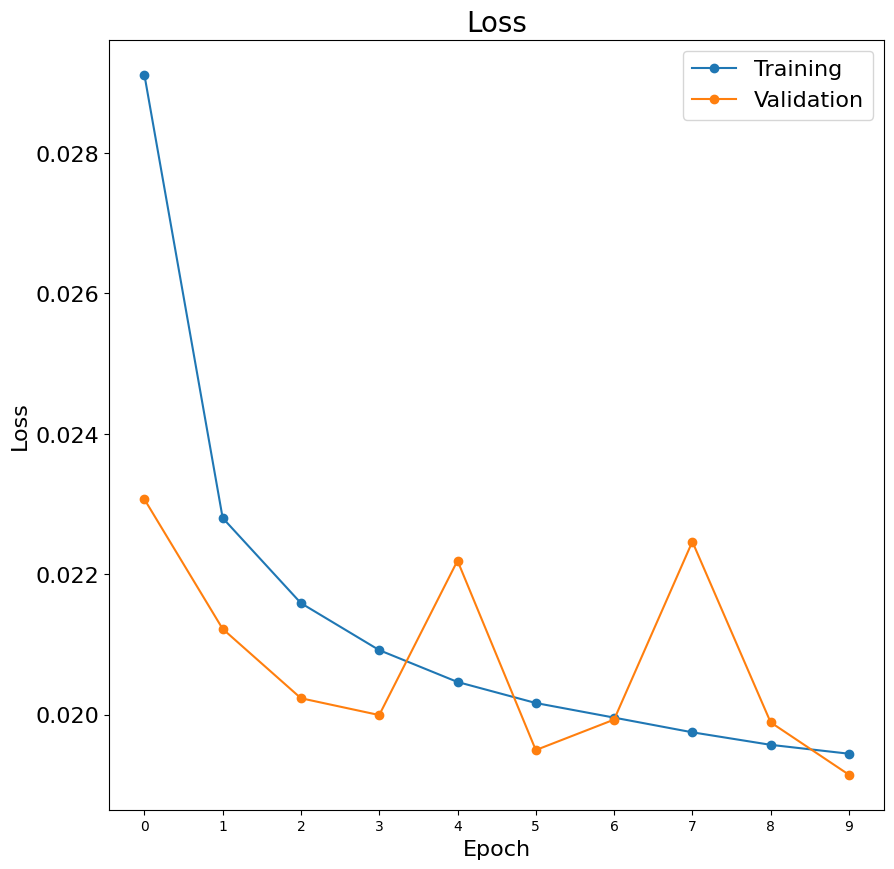

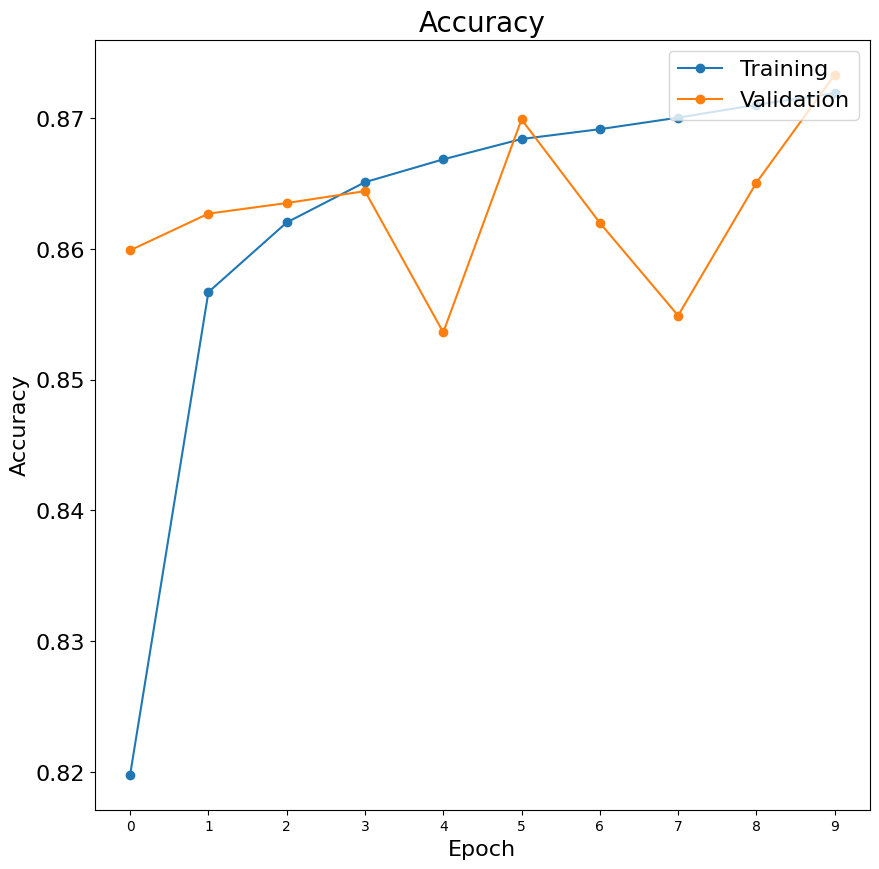

In [48]:
#  create epoch-loss graph
plt.figure(figsize=(10, 10))
plt.plot(track_epoch, training_loss, marker='o')
plt.plot(track_epoch, validation_loss, marker='o')
epoch_int = range(math.floor(min(track_epoch)), math.ceil(max(track_epoch)) + 1)
plt.xticks(epoch_int, fontsize=10)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training', 'Validation'], loc='upper right', fontsize=16)
plt.title('Loss', fontsize=20)
plt.savefig('epoch_loss')
plt.show()

# create epoch-accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(track_epoch, training_accuracy, marker='o')
plt.plot(track_epoch, validation_accuracy, marker='o')
epoch_int = range(math.floor(min(track_epoch)), math.ceil(max(track_epoch)) + 1)
plt.xticks(epoch_int, fontsize=10)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training', 'Validation'], loc='upper right', fontsize=16)
plt.title('Accuracy', fontsize=20)
plt.savefig('epoch_acc')
plt.show()

Test Set: Loss 0.0189890631554775, Accuracy 0.8747093651995241


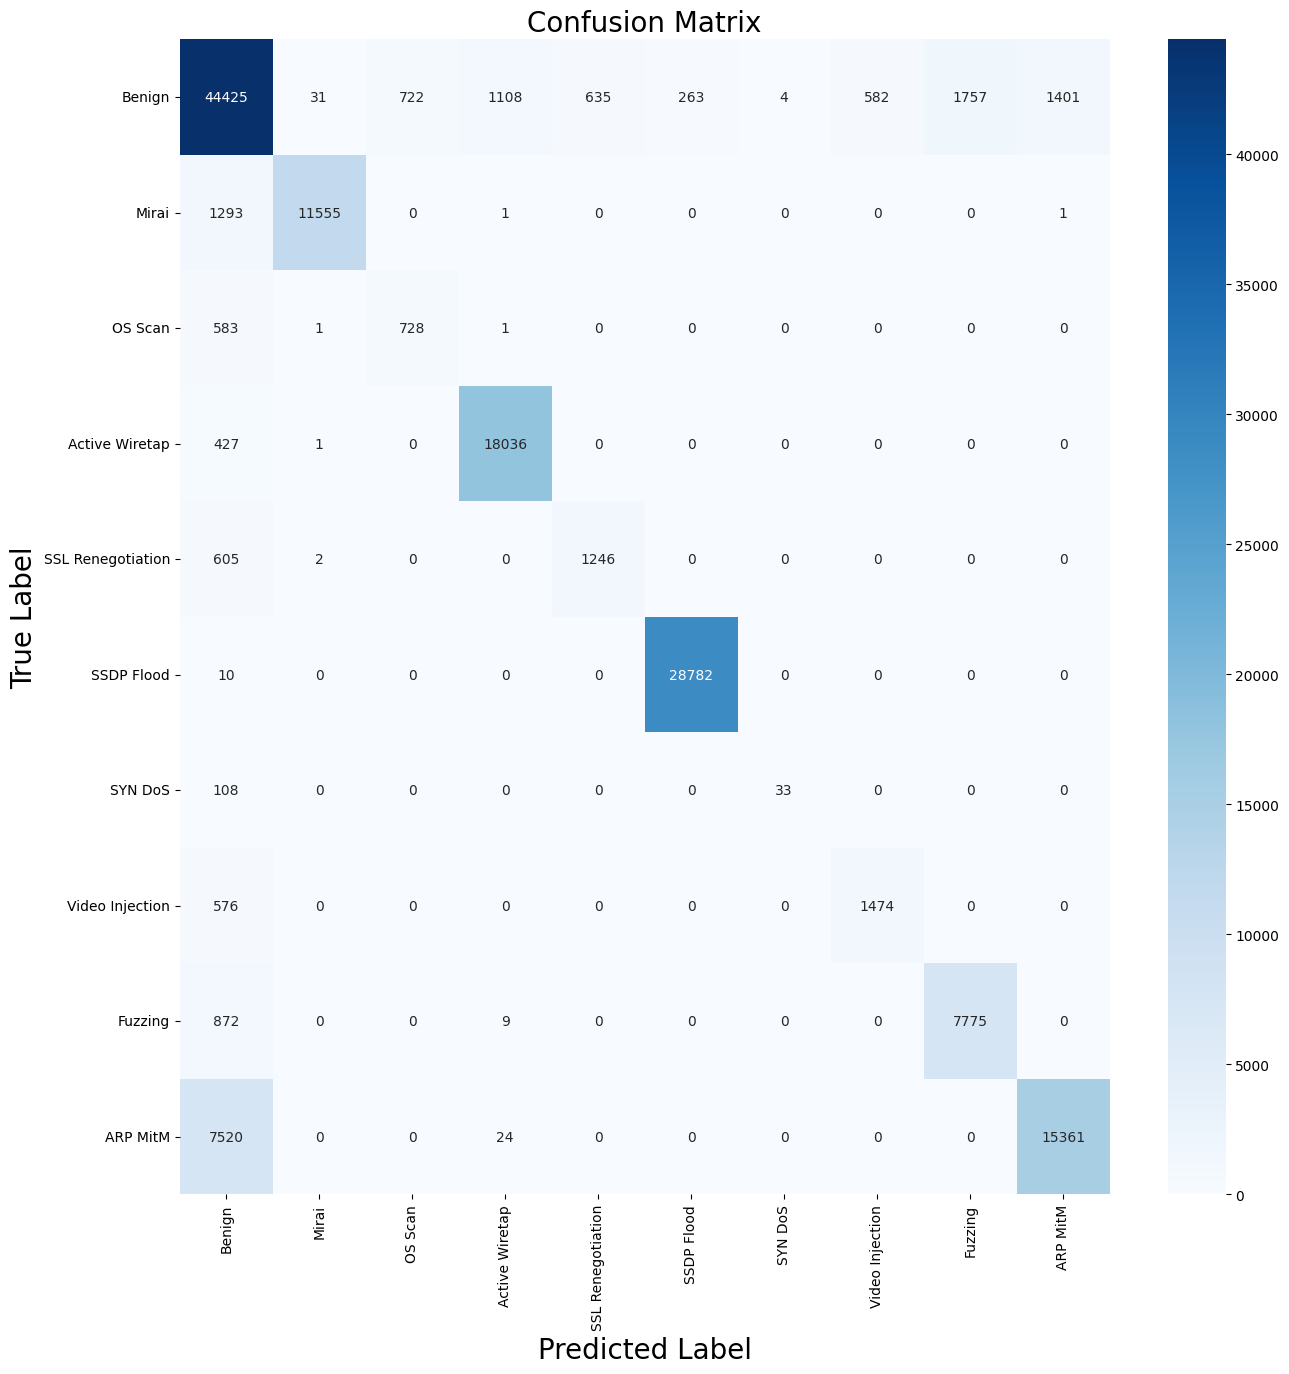

                   precision    recall  f1-score   support

           Benign       0.79      0.87      0.83     50928
            Mirai       1.00      0.90      0.95     12850
          OS Scan       0.50      0.55      0.53      1313
   Active Wiretap       0.94      0.98      0.96     18464
SSL Renegotiation       0.66      0.67      0.67      1853
       SSDP Flood       0.99      1.00      1.00     28792
          SYN DoS       0.89      0.23      0.37       141
  Video Injection       0.72      0.72      0.72      2050
          Fuzzing       0.82      0.90      0.85      8656
         ARP MitM       0.92      0.67      0.77     22905

         accuracy                           0.87    147952
        macro avg       0.82      0.75      0.76    147952
     weighted avg       0.88      0.87      0.87    147952



In [60]:
# centralised learning evaluation on the test set
# load model from a save, if not trained at present:
CENTRALISED_MODEL_PATH = '/content/gdrive/My Drive/Thesis Data/models/centralised_k50.pt'
model = DNN(num_classes=10, input_size=50, hidden_size=32, num_layers=1).to(DEVICE)
model.load_state_dict(torch.load(CENTRALISED_MODEL_PATH))

# evaluate centralised model on test set
test_loss, test_acc, true_class, pred_class = log_test(model, testloader)
print(f"Test Set: Loss {test_loss}, Accuracy {test_acc}")

# view a confusion matrix of the test set results
cm = confusion_matrix(true_class, pred_class)
class_labels = list(CLASSES.values())
tick_marks = np.arange(len(class_labels))
df_cm = pd.DataFrame(cm, index = class_labels, columns = class_labels)
plt.figure(figsize = (15,15))
hm = sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted Label", fontsize=20)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
plt.ylabel("True Label", fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.savefig('/content/gdrive/My Drive/Thesis Data/eval/cm/centralised_cm_k50')
plt.show()

# print precision and recall
centralised_results = classification_report(true_class, pred_class, target_names=class_labels)
print(centralised_results)


In [61]:
# save results
with open('/content/gdrive/My Drive/Thesis Data/eval/centralised_results_k50.txt', 'w') as f:
    f.write(centralised_results)
